# Text 3: Latent Dirichlet allocation
**Internet Analytics - Lab 4**

---

**Group:** *J*

**Names:**

* *Name 1*
* *Name 2*
* *Name 3*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [2]:
#Newest

# Imports
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import CountVectorizer , IDF, VectorAssembler
import contractions
import demoji
import string
import nltk
nltk.data.path.append('/path/to/nltk_data')
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import re
from pyspark.sql import SparkSession
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import LDA


DIR = "./data/"

/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


#### Preprocessing

In [181]:
# Load data
from utils import load_json
import pandas as pd

# Load JSON data from a text file into a Pandas DataFrame
data = pd.read_json('{}courses.txt'.format(DIR), lines=True)

In [168]:
# Preprocessing of data
def data_preprocessing(df, col):
    text_col = df[f'{col}']
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    
     # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))
    
    # split into words
    text_col = text_col.apply(lambda x: x.split())
    
    df['Text'] = text_col
    return df

In [182]:
data = data_preprocessing(data, 'description')

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(data)

# Show the Spark DataFrame
spark_df.show()

+----------+--------------------+--------------------+--------------------+
|  courseId|         description|                name|                Text|
+----------+--------------------+--------------------+--------------------+
|   MSE-440|The latest develo...|Composites techno...|[latest, developm...|
|   BIO-695|This course inten...|Image Processing ...|[course, intends,...|
|   FIN-523|This course provi...|Global business e...|[course, provides...|
| MICRO-614|This course is fo...|Electrochemical n...|[course, focused,...|
| ME-231(a)|This course aims ...|Structural mechan...|[course, aim, pro...|
| AR-402(v)|Over the course t...|Théorie et critiq...|[course, time, ra...|
|   ChE-421|This course is a ...|Advanced principl...|[course, natural,...|
|    CH-403|Become familiar w...|   Mass spectrometry|[become, familiar...|
|   COM-302|This course is on...|Principles of dig...|[course, foundati...|
|    EE-432|Creation and use ...|Hardware systems ...|[creation, use, m...|
|   MGT-430|

In [11]:
# The fitted model learns the vocabulary based on the input data and applies it to transform the text documents
cv = CountVectorizer(inputCol="Text", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(spark_df)

 # The result contains the raw features as a sparse vector in the "raw_features" column
result_cv = cvmodel.transform(spark_df)

# Retrieves the learned vocabulary from the CountVectorizer model
vocabulary = cvmodel.vocabulary


# IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Transforms the DataFrame with raw features using the fitted IDF model
# The result contains the TF-IDF weighted features as a sparse vector in the "features" column
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

## Exercise 4.8: Topics extraction

#### Print k = 10 topics extracted using LDA

In [12]:
# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector_features')
assembled_df = assembler.transform(result_tfidf[['courseId', 'features']])

# Define the number of topics and maximum iterations
num_topics = 10
max_iterations = 100

# Train LDA model
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(assembled_df)

In [165]:
# Get the topics from the LDA model
def get_topics(lda_model, vocabulary):
    topics = lda_model.describeTopics().collect()

    for topic in topics:
        print("Topic: {}".format(topic.topic))
        for i, idx in enumerate(topic.termIndices):
            print("{}. {}: {}".format(idx, vocabulary[idx], topic.termWeights[i]))
        print(" ")
    return topics

#get_topics(lda_model)

#### Give labels to topics

In [14]:
topics_title = [
    'Report',
    'Architectural studies',
    'Optical Analysis',
    'Machine Learning',
    'Fluid Mechanics',
    'Nuclear Chemistry',
    'Development of buissness applications',
    'Physics',
    'Economic',
    'Genetics'
]

for i, topic in enumerate(topics):
    print("Topic {}: {}".format(topic.topic, topics_title[i]))

Topic 0: Report
Topic 1: Architectural studies
Topic 2: Optical Analysis
Topic 3: Machine Learning
Topic 4: Fluid Mechanics
Topic 5: Nuclear Chemistry
Topic 6: Development of buissness applications
Topic 7: Physics
Topic 8: Economic
Topic 9: Genetics


#### How does it compare with LSI?
TODO:

## Exercise 4.9: Dirichlet hyperparameters

In [87]:
# Calculate cosine similarity between topic_i and topic_j
def calculate_similarity(topic_i, topic_j):
    similarity = cosine_similarity(topic_i.reshape(1, -1), topic_j.reshape(1, -1))
    return similarity[0, 0]

# Define metrics to compare diversity across the topics
def calculate_topic_diversity(lda_model, num_topics, top_n=10):
    topic_terms = lda_model.topicsMatrix().toArray()

    topic_similarity = np.zeros((num_topics, num_topics))

    for i in range(num_topics):
        topic_i = topic_terms[i, :]
        for j in range(i + 1, num_topics):
            topic_j = topic_terms[j, :]
            similarity = calculate_similarity(topic_i, topic_j)
            topic_similarity[i, j] = similarity
            topic_similarity[j, i] = similarity

    diversity_score = np.mean(topic_similarity)
    return diversity_score

In [115]:
# Evaluation of models with different parameters
def models_evaulation(df, alfas, betas, num_topics, max_iterations, vary_alfa, verobse=False):
    
    models = []
    log_likelihoods = []
    log_perplexities = []
    topic_divercities = []
    
    # choose parameter to vary
    if vary_alfa:
        topicConcentration = betas

        for alfa in alfas:
            docConcentration = [alfa for t in range(num_topics)]
            lda_model = LDA(k=num_topics, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
            model = lda_model.fit(df)
            models.append(model)
    else:
        docConcentration = [alfas for t in range(num_topics)]
        
        for beta in betas:
            topicConcentration = beta
            lda_model = LDA(k=num_topics, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
            model = lda_model.fit(df)
            models.append(model)
    
        
    # Evaluate the models
    for i, model in enumerate(models):
        if vary_alfa:
            alfa = alfas[i]
        else:
            beta = betas[i]
        
        # Store values of metrics
        ll = model.logLikelihood(df)
        lp = model.logPerplexity(df)
        td = calculate_topic_diversity(model, num_topics)

        log_likelihoods.append(ll)
        log_perplexities.append(lp)
        topic_divercities.append(td)
        
        # Display informations about each model and his topics
        if verobse:
            print(f"Model with alfa={alfa} and beta={beta} has log likelihood={ll} and log perplexity={lp}")
            topics = model.describeTopics(maxTermsPerTopic=3)
            print(f"The topics described by their top-weighted terms for alfa={alfa} are:")
            topics.show(truncate=False)
    return log_likelihoods, log_perplexities, topic_divercities

In [112]:
# To display the graph in the notebook
%matplotlib inline

# Store metrics on the graph
def display_metrics(hyperparameters, hyperparameter_name, log_likelihoods, log_perplexities, topic_diversities):
    x = hyperparameters

    # Create the figure and the first subplot
    fig, ax1 = plt.subplots()

    # Plot the log likelihoods on the left y-axis
    ax1.plot(x, log_likelihoods, marker='o', color='blue')
    ax1.set_xlabel(f'Values of {hyperparameter_name}')
    ax1.set_ylabel('Log Likelihood', color='blue')
    ax1.tick_params('y', colors='blue')

    # Create the second subplot and link it to the first subplot
    ax2 = ax1.twinx()

    # Plot the log perplexities on the right y-axis
    ax2.plot(x, log_perplexities, marker='s', color='red')
    ax2.set_ylabel('Log Perplexities', color='red')
    ax2.tick_params('y', colors='red')
    
    # Create the third subplot and link it to the first subplot, adjust its position
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Adjust the position of the third y-axis

    # Plot the topic diversities on the right y-axis
    ax3.plot(x, topic_diversities, marker='s', color='green')
    ax3.set_ylabel('Topic Diversities', color='green')
    ax3.tick_params('y', colors='green')

    # Adjust the position of the first y-axis (blue)
    ax1.spines['left'].set_position(('outward', 60))

    # Add title
    plt.title('Log Likelihood, Log Perplexities, and Topic Diversities Evaluation')
    
    # Set the legends for each subplot
    ax1.legend(['Log Likelihood'], loc='upper left')
    ax2.legend(['Log Perplexities'], loc='upper right')
    ax3.legend(['Topic Diversities'], loc='lower right')

    # Set xticks
    ax1.set_xticks(x)
    ax1.set_xticklabels(x, rotation=90)  # Rotate x-tick labels by 90 degrees

    # Display the graph
    plt.show()

##### Interpretation of metrics:

- Higher log likelihood or lower perplexity indicate better model fit.

- Topic diversity is a measure used in topic modeling to assess the dissimilarity or distinctiveness of topics in a given corpus. It provides insights into how different the topics are from each other, indicating the breadth and variety of the discovered themes.

- The output of a topic diversity measure is typically a numerical score that quantifies the degree of dissimilarity among the topics. Lower scores indicate higher diversity, meaning the topics are more distinct from each other. Conversely, higher scores suggest more overlap or similarity between topics.

#### Fix k = 10 and β = 1.01, and **vary α***
where:

k - number of topics

β - the distribution of words in topics

α - the distribution of topics in documents

Values of these parameters should be positive

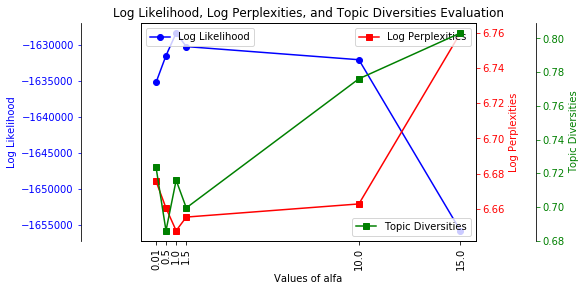

In [143]:
alfas = [0.01, 0.5, 1.0, 1.5, 10.0, 15.0] 
betas = 1.01

log_likelihoods, log_perplexities, topic_divercities = models_evaulation(assembled_df, alfas, betas, num_topics, max_iterations, vary_alfa=True, verobse=False)

display_metrics(alfas, 'alfa', log_likelihoods, log_perplexities, topic_divercities)

In [153]:
# alfa = 1.01 (chosen as the best parameter according to metric)
alfa = 1.0
beta = 1.01
docConcentration = [alfa for t in range(num_topics)]
topicConcentration = beta

lda = LDA(k=num_topics, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
lda_model = lda.fit(assembled_df)
get_topics(lda_model)

Topic: 0
96. algorithm: 0.011682853886754037
72. linear: 0.011475336975606251
150. probability: 0.009430762558836247
7. model: 0.009141136990744538
151. optimization: 0.009062164674454198
119. numerical: 0.008613544101481602
195. statistical: 0.008163317329039667
29. problem: 0.00786693443904604
32. theory: 0.007823469391588731
127. simulation: 0.00709160846864715
 
Topic: 1
36. energy: 0.012833626610750682
25. material: 0.011127760832847059
126. circuit: 0.010902483111500886
125. device: 0.010658484333012204
193. electronic: 0.008562448425683756
249. magnetic: 0.008555117770106821
56. property: 0.008007096491327382
325. semiconductor: 0.007505027868799117
298. electronics: 0.0070650745522206695
473. transistor: 0.006785357357879437
 
Topic: 2
178. laser: 0.02080928031590989
109. optical: 0.016391478344979876
169. optic: 0.01617776048398975
102. programming: 0.012375399903349934
4. system: 0.010768064952364837
245. measurement: 0.009923853984026853
500. fiber: 0.009829509231882144
671.

[Row(topic=0, termIndices=[96, 72, 150, 7, 151, 119, 195, 29, 32, 127], termWeights=[0.011682853886754037, 0.011475336975606251, 0.009430762558836247, 0.009141136990744538, 0.009062164674454198, 0.008613544101481602, 0.008163317329039667, 0.00786693443904604, 0.007823469391588731, 0.00709160846864715]),
 Row(topic=1, termIndices=[36, 25, 126, 125, 193, 249, 56, 325, 298, 473], termWeights=[0.012833626610750682, 0.011127760832847059, 0.010902483111500886, 0.010658484333012204, 0.008562448425683756, 0.008555117770106821, 0.008007096491327382, 0.007505027868799117, 0.0070650745522206695, 0.006785357357879437]),
 Row(topic=2, termIndices=[178, 109, 169, 102, 4, 245, 500, 671, 283, 550], termWeights=[0.02080928031590989, 0.016391478344979876, 0.01617776048398975, 0.012375399903349934, 0.010768064952364837, 0.009923853984026853, 0.009829509231882144, 0.008158653679818653, 0.007781319232217912, 0.007596695762621509]),
 Row(topic=3, termIndices=[241, 98, 77, 287, 54, 149, 304, 12, 58, 44], ter

- Higher values of α encourage documents to be composed of more topics, resulting in documents with a mixture of topics. Lower values of α promote sparser document-topic distributions, where documents are primarily dominated by a few prominent topics.

#### Fix k = 10 and α = 6, and ***vary β***
where:

k - number of topics

β - the distribution of words in topics

α - the distribution of topics in documents

Values of these parameters should be positive

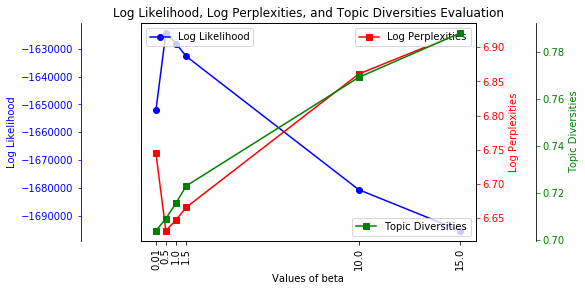

In [144]:
alfas = 1.01
betas = [0.01, 0.5, 1.0, 1.5, 10.0, 15.0]

log_likelihoods, log_perplexities, topic_divercities = models_evaulation(assembled_df, alfas, betas, num_topics, max_iterations, vary_alfa=False, verobse=False)

display_metrics(betas, 'beta', log_likelihoods, log_perplexities, topic_divercities)

In [154]:
# beta = 10 (chosen as the best parameter according to metric)
alfa = 1.01
beta = 0.5

docConcentration = [alfa for t in range(num_topics)]
topicConcentration = beta

lda = LDA(k=num_topics, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
lda_model = lda.fit(assembled_df)
get_topics(lda_model)

Topic: 0
96. algorithm: 0.012012280428584552
72. linear: 0.011726121112040619
150. probability: 0.009742825759581776
7. model: 0.009419647623494188
151. optimization: 0.009299532018619463
119. numerical: 0.008859216562360094
195. statistical: 0.008441827068354292
29. problem: 0.008095915937234155
32. theory: 0.008000311850062752
28. data: 0.007206288362004932
 
Topic: 1
36. energy: 0.013094590161136035
25. material: 0.011180532399059166
126. circuit: 0.011135731816375522
125. device: 0.010806071637816456
249. magnetic: 0.008735787362304698
193. electronic: 0.008606845196941167
56. property: 0.008149949061592702
325. semiconductor: 0.007604850100596668
298. electronics: 0.007198634995515124
473. transistor: 0.006884710963801984
 
Topic: 2
178. laser: 0.02178423470322302
109. optical: 0.01747335425481709
169. optic: 0.01696944163143387
102. programming: 0.012885365206449449
245. measurement: 0.010725336906197964
4. system: 0.010707752975364424
500. fiber: 0.010344990196752727
671. wavegu

[Row(topic=0, termIndices=[96, 72, 150, 7, 151, 119, 195, 29, 32, 28], termWeights=[0.012012280428584552, 0.011726121112040619, 0.009742825759581776, 0.009419647623494188, 0.009299532018619463, 0.008859216562360094, 0.008441827068354292, 0.008095915937234155, 0.008000311850062752, 0.007206288362004932]),
 Row(topic=1, termIndices=[36, 25, 126, 125, 249, 193, 56, 325, 298, 473], termWeights=[0.013094590161136035, 0.011180532399059166, 0.011135731816375522, 0.010806071637816456, 0.008735787362304698, 0.008606845196941167, 0.008149949061592702, 0.007604850100596668, 0.007198634995515124, 0.006884710963801984]),
 Row(topic=2, termIndices=[178, 109, 169, 102, 245, 4, 500, 671, 283, 550], termWeights=[0.02178423470322302, 0.01747335425481709, 0.01696944163143387, 0.012885365206449449, 0.010725336906197964, 0.010707752975364424, 0.010344990196752727, 0.008551178217939421, 0.008370183726165993, 0.007948983876019017]),
 Row(topic=3, termIndices=[241, 98, 77, 287, 54, 149, 304, 12, 58, 44], term

- Higher values of β make topics more evenly distributed over words, while lower values of β lead to sparser word-topic distributions, where topics are characterized by a handful of highly probable words.

###### Summary
- Higher α and β values generally lead to more diverse and general topics, while lower values can result in more focused and specific topics. 

## Exercise 4.10: EPFL's taught subjects

#### Find the combination of k, α and β that gives the most interpretable topics.

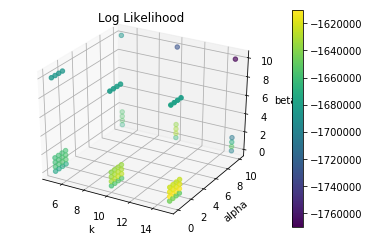

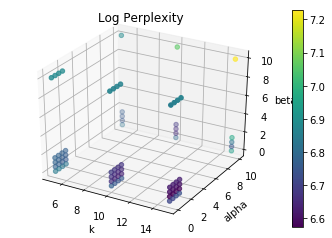

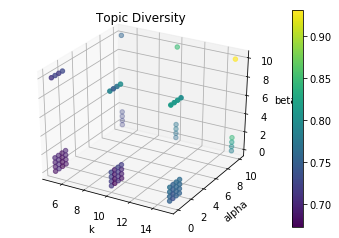

In [136]:
# To display the graph in the notebook
%matplotlib inline

k_values = [5, 10, 15]
alpha_values = [0.01, 0.5, 1.0, 1.5, 10.0]
beta_values = [0.01, 0.5, 1.0, 1.5, 10.0]

metrics = []

for k in k_values:
    for alpha in alpha_values:
        for beta in beta_values:
            
            docConcentration = [alpha for t in range(k)]
            topicConcentration = beta
            
            # Train LDA model with specific parameter values (k, alpha, beta)
            lda = LDA(k=k, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
            lda_model = lda.fit(assembled_df)
            
            # Calculate log likelihood (ll) and log perplexity (lp)
            ll = lda_model.logLikelihood(assembled_df)
            lp = lda_model.logPerplexity(assembled_df)
            
            # Calculate topic diversity (td)
            td = calculate_topic_diversity(lda_model, k)
            
            # Store the parameter values and metric values
            metrics.append((k, alpha, beta, ll, lp, td))

# Extract the parameter values and metric values for plotting
k_values = [param[0] for param in metrics]
alpha_values = [param[1] for param in metrics]
beta_values = [param[2] for param in metrics]
ll_values = [param[3] for param in metrics]
lp_values = [param[4] for param in metrics]
td_values = [param[5] for param in metrics]

# Plot log likelihood (ll)
fig_ll = plt.figure()
ax_ll = fig_ll.add_subplot(111, projection='3d')
sc_ll = ax_ll.scatter(k_values, alpha_values, beta_values, c=ll_values, cmap='viridis')
ax_ll.set_xlabel('k')
ax_ll.set_ylabel('alpha')
ax_ll.set_zlabel('beta')
ax_ll.set_title('Log Likelihood')
plt.colorbar(sc_ll)
plt.show()

# Plot log perplexity (lp)
fig_lp = plt.figure()
ax_lp = fig_lp.add_subplot(111, projection='3d')
sc_lp = ax_lp.scatter(k_values, alpha_values, beta_values, c=lp_values, cmap='viridis')
ax_lp.set_xlabel('k')
ax_lp.set_ylabel('alpha')
ax_lp.set_zlabel('beta')
ax_lp.set_title('Log Perplexity')
plt.colorbar(sc_lp)
plt.show()

# Plot topic diversity (td)
fig_td = plt.figure()
ax_td = fig_td.add_subplot(111, projection='3d')
sc_td = ax_td.scatter(k_values, alpha_values, beta_values, c=td_values, cmap='viridis')
ax_td.set_xlabel('k')
ax_td.set_ylabel('alpha')
ax_td.set_zlabel('beta')
ax_td.set_title('Topic Diversity')
plt.colorbar(sc_td)
plt.show()

In [139]:
# Find the parameter values for the highest and lowest metric values
highest_ll_idx = np.argmax(ll_values)
lowest_ll_idx = np.argmin(ll_values)
highest_lp_idx = np.argmax(lp_values)
lowest_lp_idx = np.argmin(lp_values)
highest_td_idx = np.argmax(td_values)
lowest_td_idx = np.argmin(td_values)

# Print the parameter values for the highest and lowest log likelihood
print("Highest Log Likelihood:")
print(f"k: {k_values[highest_ll_idx]}, alpha: {alpha_values[highest_ll_idx]}, beta: {beta_values[highest_ll_idx]}")
print(" ")

# Print the parameter values for the highest and lowest log likelihood
print("Lowest Log Perplexity:")
print(f"k: {k_values[lowest_lp_idx]}, alpha: {alpha_values[lowest_lp_idx]}, beta: {beta_values[lowest_lp_idx]}")
print(" ")

# Print the parameter values for the highest and lowest log likelihood
print("Highest Topic Diversity:")
print(f"k: {k_values[lowest_td_idx]}, alpha: {alpha_values[lowest_td_idx]}, beta: {beta_values[lowest_td_idx]}")

Highest Log Likelihood:
k: 15, alpha: 0.5, beta: 0.5
 
Lowest Log Perplexity:
k: 15, alpha: 0.5, beta: 0.5
 
Highest Topic Diversity:
k: 5, alpha: 1.0, beta: 0.01


#### Explain why you chose these values:
values:
- k=15

I have chosen this value, as on graphs created above, we can observe the best value of k=15, for most of metrics.
- α=1.0
- β=0.01

We want to achieve the highest diversity in topics, so I would choose for alfa=1.0 value and beta hyperparametr=0.01,  (according to third metric).

#### Report the values of the hyperparameters that you used and run model:

values of hyperparameters:
- k=15
- α=1.0
- β=0.01

In [151]:
# Get the topics from the LDA model
k = 15
alpha = 1.0
beta = 0.01

docConcentration = [alpha for t in range(k)]
topicConcentration = beta

lda = LDA(k=k, maxIter=max_iterations, seed=0, docConcentration=docConcentration, topicConcentration=topicConcentration)
lda_model = lda.fit(assembled_df)
topics = get_topics(lda_model)

Topic: 0
25. material: 0.015536947216696555
31. process: 0.012495915971709399
288. production: 0.011659079298273364
490. manufacturing: 0.011410298574588645
228. modelling: 0.010598583342822833
559. composite: 0.009632677509438227
610. corporate: 0.00962974085163472
258. product: 0.00959777558594245
286. polymer: 0.008958565303847033
6. design: 0.008925371427045945
 
Topic: 1
126. circuit: 0.023542017659068562
4. system: 0.020651506847821306
133. communication: 0.013882336300076964
6. design: 0.013484391509015944
125. device: 0.013186717926011948
159. power: 0.012993785185504344
147. architecture: 0.012638226653879632
487. analog: 0.01230224530307958
334. noise: 0.01203496772115731
526. wireless: 0.01169605322226228
 
Topic: 2
178. laser: 0.03597406485490899
109. optical: 0.03254930571681665
169. optic: 0.02731047715556656
245. measurement: 0.017338462831373455
500. fiber: 0.01727324503957932
190. imaging: 0.01716949397775884
176. microscopy: 0.015010497905994397
283. light: 0.01446735

#### Give labels to topics

In [152]:
topics_title = [
    'Industry Production',
    'Electronics',
    'Optical Analysis',
    'Economics',
    'Risk evaluation',
    'Robotics',
    'Biology',
    'Nuclear Chemistry',
    'Fluid Mechanics',
    'Research',
    'Physics',
    'Wave interference',
    'Fractals',
    'Programming',
    'Radiation'
]

for i, topic in enumerate(topics):
    print("Topic {}: {}".format(topic.topic, topics_title[i]))

Topic 0: Industry Production
Topic 1: Electronics
Topic 2: Optical Analysis
Topic 3: Economics
Topic 4: Risk evaluation
Topic 5: Robotics
Topic 6: Biology
Topic 7: Nuclear Chemistry
Topic 8: Fluid Mechanics
Topic 9: Research
Topic 10: Physics
Topic 11: Wave interference
Topic 12: Fractals
Topic 13: Programming
Topic 14: Radiation


## Exercise 4.11: Wikipedia structure

In [184]:
# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Read the text file
wikipedia_rdd = spark.sparkContext.textFile('/ix/wikipedia-for-schools.txt')

# Convert RDD to DataFrame
wikipedia_df = wikipedia_rdd.map(lambda x: (x,)).toDF(['text'])

In [185]:
# Split the text column into an array of words
wikipedia_df = wikipedia_df.withColumn("text_array", split(wikipedia_df.text, " "))

# Create CountVectorizer
cv = CountVectorizer(inputCol="text_array", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(wikipedia_df)
result_cv = cvmodel.transform(wikipedia_df)
vocabulary = cvmodel.vocabulary

# IDF transformation
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

#### Report the values for k, α and β that you chose a priori and why you picked them.

k - number of topics: 20

β - the distribution of words in topics: 0.5

α - the distribution of topics in documents: 0.01

I have chosen these values, as I believe:
- k needs to be large, because wikipedia covers plenty of topics.
- Higher values of α encourage documents to be composed of more topics, resulting in documents with a mixture of topics. Lower values of α promote sparser document-topic distributions, where documents are primarily dominated by a few prominent topics.
- Similary, higher values of β make topics more evenly distributed over words, while lower values of β lead to sparser word-topic distributions, where topics are characterized by a handful of highly probable words.
- Higher α and β values generally lead to more diverse and general topics, while lower values can result in more focused and specific topics. 

In [ ]:
# Define the number of topics and maximum iterations
num_topics = 20
alpha = 0.01
beta = 0.5

num_topics = 10
max_iterations = 100
docConcentration = [alpha for t in range(num_topics)]
topicConcentration = beta

# Train LDA model
lda = LDA(k=num_topics, maxIter=max_iterations, docConcentration=docConcentration, topicConcentration=topicConcentration)
lda_model = lda.fit(result_tfidf)

In [190]:
get_topics(lda_model, vocabulary)

Topic: 0
104. "church",: 0.0034489319413559434
89. "law",: 0.003284792094074934
65. "political",: 0.002950572390279741
235. "rights",: 0.0027574222069126925
122. "party",: 0.0026374036623346155
815. "pope",: 0.002407369939079861
59. "president",: 0.0023874899508839796
183. "social",: 0.0022450919741708085
92. "house",: 0.002239270678848061
264. "god",: 0.0022167870600921053
 
Topic: 1
45. "species",: 0.011716791890934265
616. "birds",: 0.004773455459814253
759. "genus",: 0.0038869765704197816
374. "animals",: 0.0037254697879510845
2123. "subspecies",: 0.0035951114304080575
639. "humans",: 0.0033246933762563543
679. "stars",: 0.0031685768080096134
758. "universe",: 0.003049001192957654
3135. "nintendo",: 0.0028080560990306172
176. "space",: 0.002727544411881663
 
Topic: 2
209. "game",: 0.00840406453170767
52. "england",: 0.00777398657247658
483. "players",: 0.007314407983543109
454. "wales",: 0.0068702179870362345
387. "scotland",: 0.00623495730059673
347. "games",: 0.00609173282318444


[Row(topic=0, termIndices=[104, 89, 65, 235, 122, 815, 59, 183, 92, 264], termWeights=[0.0034489319413559434, 0.003284792094074934, 0.002950572390279741, 0.0027574222069126925, 0.0026374036623346155, 0.002407369939079861, 0.0023874899508839796, 0.0022450919741708085, 0.002239270678848061, 0.0022167870600921053]),
 Row(topic=1, termIndices=[45, 616, 759, 374, 2123, 639, 679, 758, 3135, 176], termWeights=[0.011716791890934265, 0.004773455459814253, 0.0038869765704197816, 0.0037254697879510845, 0.0035951114304080575, 0.0033246933762563543, 0.0031685768080096134, 0.003049001192957654, 0.0028080560990306172, 0.002727544411881663]),
 Row(topic=2, termIndices=[209, 52, 483, 454, 387, 347, 293, 231, 516, 966], termWeights=[0.00840406453170767, 0.00777398657247658, 0.007314407983543109, 0.0068702179870362345, 0.00623495730059673, 0.00609173282318444, 0.00592593326322576, 0.0054364547440809135, 0.005148479472837939, 0.005050592084049816]),
 Row(topic=3, termIndices=[187, 95, 6, 388, 40, 38, 51, 

#### Are you convinced by the results? Give labels to the topics if possible.